In [1]:
# # Pytorch Cuda 오류발생시 해당 코드를 활성화하여
# # 좀더 자세한 오류 원인을 찾자!
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'    # CUDA 커널 호출을 동기화
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"    # 0번 GPU에서만 연산을 수행하게 강제
# os.environ["TORCH_USE_CUDA_DSA"] = '1'      # CUDA 커널 내부에서 assert 구문 적용

In [2]:
import torch
import darknet53_FPN as darknet53
from Yolov3_model import YOLOv3, FPN, features_shape, debug

from yolo_dataset import CustomDataset, anchor_box_list
from yolo_v3_loss import Yolov3Loss, loss_debug

# yolo_v3_metrics파일은 ModelTrainer.py에 import되기에 여기서는 추가 안해도 됨
# from yolo_v3_metrics import YOLOv3Metrics, anchor_box_list, metrics_debug
from ModelTrainer import ModelTrainer

from tqdm import tqdm
import logging

In [3]:
# 모델 초기화(backbone는 사전학습모델 로드)
backbone = darknet53.Darknet53(pretrained=True)
fpn = FPN(channels_list=features_shape)
yolov3 = YOLOv3(backbone, fpn, num_classes=80)

In [4]:
# 백본 파라미터 Freeze
for param in backbone.parameters():
    param.requires_grad = False

In [5]:
# coco데이터셋의 메인 루트 디렉토리
root_dir = './../00_pytest_img/COCO dataset'
# 데이터셋 생성
train_dataset = CustomDataset(root=root_dir, img_set='train', anchor=anchor_box_list)
test_dataset = CustomDataset(root=root_dir, img_set='val', anchor=anchor_box_list)

loading annotations into memory...
Done (t=4.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


In [6]:
from torchvision.transforms import v2

coco_val = [[0.4678, 0.4454, 0.4067], [0.2379, 0.2329, 0.2363]]
# 데이터셋 전처리 방법론 정의
transforamtion = v2.Compose([
    v2.Resize((416, 416)), #이미지 크기를 416, 416로
    v2.ToImage(),  # 이미지를 Tensor 자료형으로 변환
    v2.ToDtype(torch.float32, scale=True), #텐서 자료형을 [0~1]로 스케일링
    v2.Normalize(mean=coco_val[0], std=coco_val[1]) #데이터셋 정규화
])

In [7]:
# 데이터셋 전처리 방법론 적용
train_dataset.transform = transforamtion
test_dataset.transform = transforamtion

In [8]:
# def check_dataset(dataset):
#     for idx in tqdm(range(len(dataset))):
#         image, label_matrices = dataset[idx]
        
#         # 이미지 텐서 체크
#         if torch.isnan(image).any() or torch.isinf(image).any():
#             logging.error(f"NaN or Inf value found in image of index {idx}")
#             raise ValueError(f"NaN or Inf value found in image of index {idx}")
        
#         # 라벨 매트릭스 체크
#         for i, label_matrix in enumerate(label_matrices):
#             if torch.isnan(label_matrix).any() or torch.isinf(label_matrix).any():
#                 nan_inf_indices = torch.nonzero(torch.isnan(label_matrix) | torch.isinf(label_matrix))
#                 for nan_inf_index in nan_inf_indices:
#                     a, b, c = nan_inf_index.tolist()
#                     logging.error(f"NaN or Inf value found in label matrix {i} of index {idx} at position ({a}, {b}, {c})")
#                     print(f"NaN or Inf value found in label matrix {i} of index {idx} at position ({a}, {b}, {c})")
#                 raise ValueError(f"NaN or Inf value found in label matrix {i} of index {idx}")
# # 데이터셋 검증 수행
# check_dataset(train_dataset)
# check_dataset(test_dataset)

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128
# 전처리가 완료된 데이터셋의 데이터로더 전환
train_loader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_loader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [10]:
# # 데이터셋 검증 함수 정의
# def check_dataloader(loader):
#     for batch_idx, (inputs, targets) in tqdm(enumerate(loader)):
#         # inputs가 리스트인 경우
#         for input_tensor in inputs:
#             if torch.isnan(input_tensor).any() or torch.isinf(input_tensor).any():
#                 logging.error(f"NaN or Inf value found in inputs of batch {batch_idx}")
#                 raise ValueError(f"NaN or Inf value found in inputs of batch {batch_idx}")
        
#         # targets가 리스트인 경우
#         for target_tensor in targets:
#             if torch.isnan(target_tensor).any() or torch.isinf(target_tensor).any():
#                 logging.error(f"NaN or Inf value found in targets of batch {batch_idx}")
#                 raise ValueError(f"NaN or Inf value found in targets of batch {batch_idx}")
            
# # 데이터 로더에 대해 유효성 검사 수행
# check_dataloader(train_loader)
# check_dataloader(test_loader)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 앞서 선언한 모델의 GPU이전
backbone.to(device)
fpn.to(device)
yolov3.to(device)

YOLOv3(
  (backbone): Darknet53(
    (stem): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1)
      )
    )
    (res_conv_1): Sequential(
      (0): Residual_block(
        (conv1): BasicConv2d(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): LeakyReLU(negative_slope=0.1)
        )
        (conv2): BasicConv2d(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), st

In [12]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# 손실 함수 설정 (YOLOv3 손실 함수)
criterion = Yolov3Loss()

# 옵티마이저 설정 (프리즈되지 않은 파라미터만)
optimizer = AdamW(filter(lambda p: p.requires_grad, yolov3.parameters()), lr=1e-3, weight_decay=1e-4)
# 스케줄러 설정 (50 에폭 기준 Cosine Annealing)
scheduler = CosineAnnealingLR(optimizer, T_max=100)

In [13]:
# Train / eval(Val)을 수행하는 클래스 인스턴스화
epoch_step = 8
trainer = ModelTrainer(epoch_step=epoch_step)

In [14]:
# 학습과 검증 손실 및 정확도를 저장할 리스트
his_loss = []
his_KPI = []
num_epoch = 80

for epoch in range(num_epoch):
    # 훈련 손실과 훈련 성과지표를 반환 받습니다.
    train_loss, train_KPI = trainer.model_train(yolov3, train_loader, 
                                                criterion, optimizer, scheduler, 
                                                device, epoch)

    # 검증 손실과 검증 성과지표를 반환 받습니다.
    test_loss, test_KPI = trainer.model_evaluate(yolov3, test_loader, 
                                                 criterion, device, epoch)

    # 손실과 성능지표를 리스트에 저장
    his_loss.append((train_loss, test_loss))
    his_KPI.append((train_KPI, test_KPI))

    # epoch가 특정 배수일 때만 출력하기
    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}," + "\t" + 
              f"Training loss: {train_loss:.4f}")
        print(f"Train KPI[ IOU: {train_KPI[0]:.4f}, "+
              f"Precision: {train_KPI[1]:.4f}, "+
              f"Recall: {train_KPI[2]:.4f}, "+ 
              f"Top1_err: {train_KPI[3]:.4f} ]")
        print(f"epoch {epoch+1:03d}," + "\t" + 
              f"Test loss: {test_loss:.4f}")
        print(f"Test KPI[ IOU: {test_KPI[0]:.4f}, "+
              f"Precision: {test_KPI[1]:.4f}, "+
              f"Recall: {test_KPI[2]:.4f}, "+
              f"Top1_err: {test_KPI[3]:.4f} ]")

[훈련중] Loss: 101262.65, KPI: [0.808, 0.016, 0.904, 0.969]: 100%|██████████| 317/317 [13:22<00:00,  2.53s/it]
100%|██████████| 40/40 [01:32<00:00,  2.30s/it]


epoch 001,	Training loss: 101262.6536
Train KPI[ IOU: 0.8084, Precision: 0.0158, Recall: 0.9038, Top1_err: 0.9691 ]
epoch 001,	Test loss: 76454.5367
Test KPI[ IOU: 0.8086, Precision: 0.0162, Recall: 0.8799, Top1_err: 0.9232 ]


[훈련중] Loss: 42009.13, KPI: [0.809, 0.016, 0.968, 0.393]: 100%|██████████| 317/317 [12:51<00:00,  2.43s/it]
100%|██████████| 40/40 [01:29<00:00,  2.23s/it]


epoch 008,	Training loss: 42009.1331
Train KPI[ IOU: 0.8090, Precision: 0.0163, Recall: 0.9677, Top1_err: 0.3925 ]
epoch 008,	Test loss: 48572.2453
Test KPI[ IOU: 0.8090, Precision: 0.0164, Recall: 0.9143, Top1_err: 0.3608 ]


[훈련중] Loss: 34246.53, KPI: [0.809, 0.016, 0.980, 0.280]: 100%|██████████| 317/317 [13:05<00:00,  2.48s/it]
100%|██████████| 40/40 [01:29<00:00,  2.25s/it]


epoch 016,	Training loss: 34246.5314
Train KPI[ IOU: 0.8092, Precision: 0.0163, Recall: 0.9796, Top1_err: 0.2795 ]
epoch 016,	Test loss: 37528.2863
Test KPI[ IOU: 0.8092, Precision: 0.0164, Recall: 0.9208, Top1_err: 0.2505 ]


[훈련중] Loss: 23243.48, KPI: [0.809, 0.016, 0.988, 0.163]: 100%|██████████| 317/317 [13:27<00:00,  2.55s/it]
100%|██████████| 40/40 [01:34<00:00,  2.35s/it]


epoch 024,	Training loss: 23243.4838
Train KPI[ IOU: 0.8093, Precision: 0.0163, Recall: 0.9876, Top1_err: 0.1630 ]
epoch 024,	Test loss: 29069.5726
Test KPI[ IOU: 0.8092, Precision: 0.0165, Recall: 0.9603, Top1_err: 0.1811 ]


[훈련중] Loss: 15323.93, KPI: [0.809, 0.016, 0.991, 0.086]: 100%|██████████| 317/317 [13:04<00:00,  2.48s/it]
100%|██████████| 40/40 [01:30<00:00,  2.27s/it]


epoch 032,	Training loss: 15323.9296
Train KPI[ IOU: 0.8094, Precision: 0.0164, Recall: 0.9907, Top1_err: 0.0864 ]
epoch 032,	Test loss: 16572.4970
Test KPI[ IOU: 0.8094, Precision: 0.0166, Recall: 0.9751, Top1_err: 0.0623 ]


[훈련중] Loss: 11225.52, KPI: [0.809, 0.016, 0.992, 0.048]: 100%|██████████| 317/317 [13:05<00:00,  2.48s/it]
100%|██████████| 40/40 [01:31<00:00,  2.28s/it]


epoch 040,	Training loss: 11225.5203
Train KPI[ IOU: 0.8094, Precision: 0.0164, Recall: 0.9923, Top1_err: 0.0484 ]
epoch 040,	Test loss: 13503.7302
Test KPI[ IOU: 0.8094, Precision: 0.0166, Recall: 0.9800, Top1_err: 0.0350 ]


[훈련중] Loss: 8267.36, KPI: [0.809, 0.016, 0.994, 0.027]: 100%|██████████| 317/317 [13:05<00:00,  2.48s/it]
100%|██████████| 40/40 [01:31<00:00,  2.29s/it]


epoch 048,	Training loss: 8267.3621
Train KPI[ IOU: 0.8095, Precision: 0.0164, Recall: 0.9937, Top1_err: 0.0266 ]
epoch 048,	Test loss: 14198.1446
Test KPI[ IOU: 0.8093, Precision: 0.0166, Recall: 0.9857, Top1_err: 0.0387 ]


[훈련중] Loss: 6611.99, KPI: [0.810, 0.016, 0.995, 0.017]: 100%|██████████| 317/317 [13:08<00:00,  2.49s/it]
100%|██████████| 40/40 [01:31<00:00,  2.28s/it]


epoch 056,	Training loss: 6611.9882
Train KPI[ IOU: 0.8095, Precision: 0.0164, Recall: 0.9946, Top1_err: 0.0169 ]
epoch 056,	Test loss: 10681.1095
Test KPI[ IOU: 0.8095, Precision: 0.0166, Recall: 0.9878, Top1_err: 0.0124 ]


[훈련중] Loss: 5565.44, KPI: [0.810, 0.016, 0.995, 0.012]: 100%|██████████| 317/317 [13:04<00:00,  2.48s/it]
100%|██████████| 40/40 [01:30<00:00,  2.27s/it]


epoch 064,	Training loss: 5565.4450
Train KPI[ IOU: 0.8095, Precision: 0.0164, Recall: 0.9953, Top1_err: 0.0122 ]
epoch 064,	Test loss: 10028.1285
Test KPI[ IOU: 0.8095, Precision: 0.0166, Recall: 0.9902, Top1_err: 0.0119 ]


[훈련중] Loss: 4692.25, KPI: [0.810, 0.016, 0.996, 0.009]: 100%|██████████| 317/317 [13:07<00:00,  2.49s/it]
100%|██████████| 40/40 [01:31<00:00,  2.28s/it]


epoch 072,	Training loss: 4692.2519
Train KPI[ IOU: 0.8095, Precision: 0.0164, Recall: 0.9959, Top1_err: 0.0090 ]
epoch 072,	Test loss: 13455.6472
Test KPI[ IOU: 0.8094, Precision: 0.0166, Recall: 0.9863, Top1_err: 0.0189 ]


[훈련중] Loss: 4228.97, KPI: [0.810, 0.016, 0.996, 0.008]: 100%|██████████| 317/317 [14:04<00:00,  2.66s/it]
100%|██████████| 40/40 [01:34<00:00,  2.35s/it]

epoch 080,	Training loss: 4228.9711
Train KPI[ IOU: 0.8096, Precision: 0.0164, Recall: 0.9964, Top1_err: 0.0075 ]
epoch 080,	Test loss: 9882.0833
Test KPI[ IOU: 0.8096, Precision: 0.0166, Recall: 0.9937, Top1_err: 0.0078 ]


In [15]:
MODEL_NAME="Yolo_v3"

torch.save(yolov3.state_dict(), f'{MODEL_NAME}.pth')

## 작성된 `Yolo_v3.pth` 파일의 다운로드 경로 
https://drive.google.com/file/d/1-4LeXHvCtCvx3k4fgfjVRznulnGU6Hmx/view?usp=drive_link

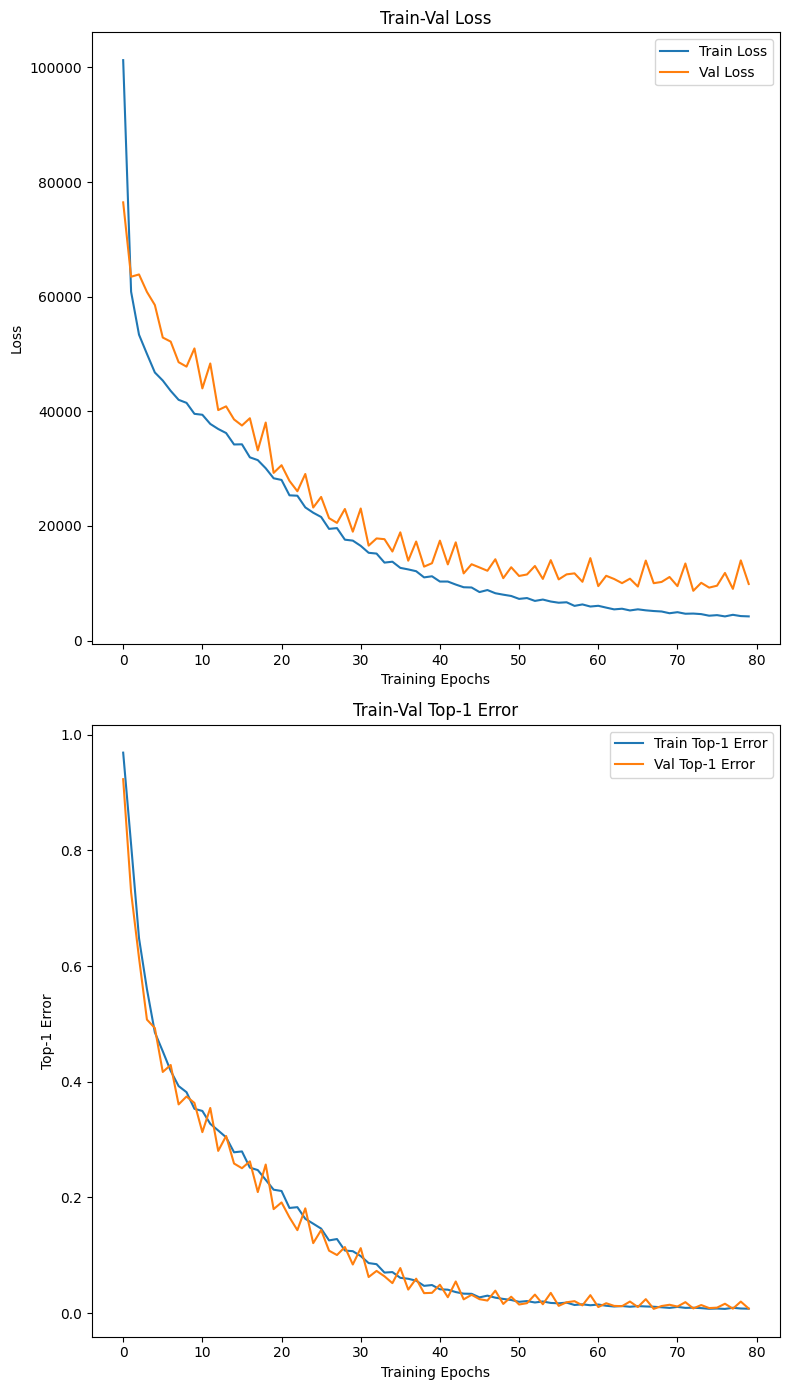

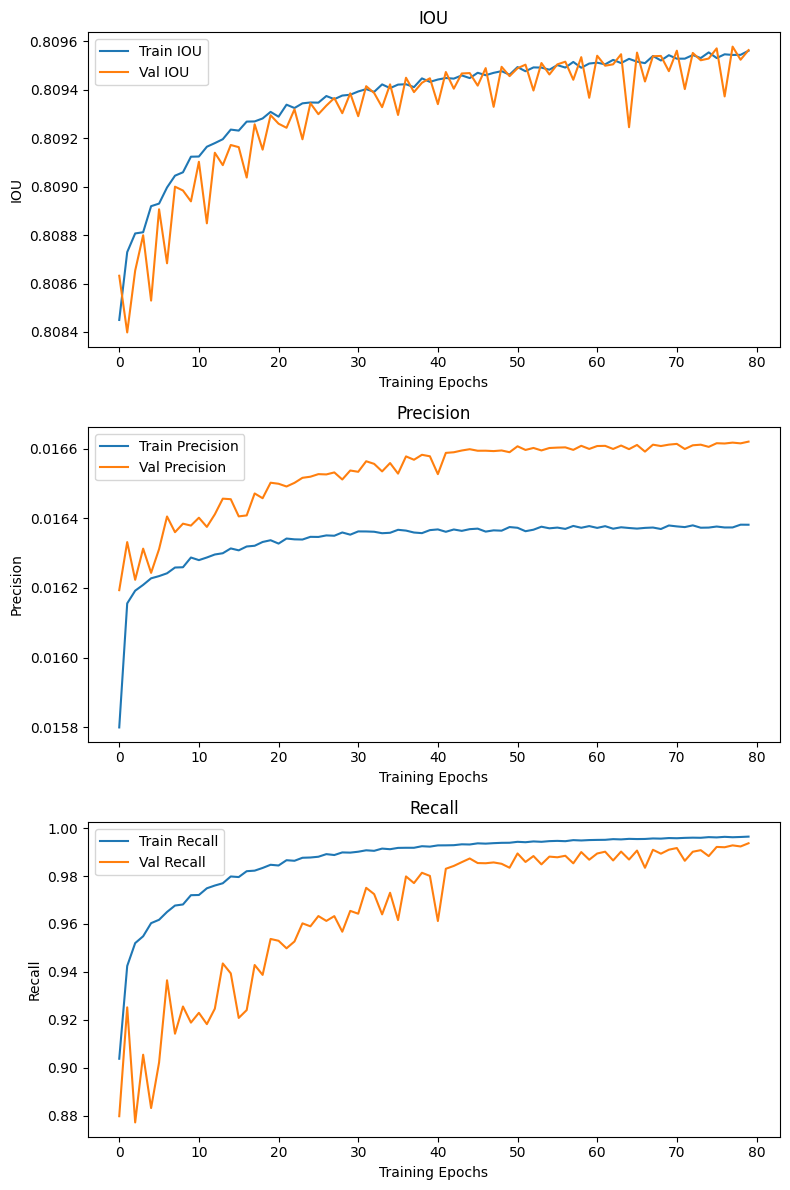

In [17]:
import numpy as np
import matplotlib.pyplot as plt
#histroy는 [train, test] 순임
#KPI는 [iou, precision, recall, top1_error] 순임
np_his_loss = np.array(his_loss)
np_his_KPI = np.array(his_KPI)

# his_loss에서 손실 데이터 추출
train_loss, val_loss = np_his_loss[..., 0], np_his_loss[..., 1]

# his_KPI에서 각 성능 지표 추출
train_iou, val_iou = np_his_KPI[..., 0, 0], np_his_KPI[..., 1, 0]
train_precision, val_precision = np_his_KPI[..., 0, 1], np_his_KPI[..., 1, 1]
train_recall, val_recall = np_his_KPI[..., 0, 2], np_his_KPI[..., 1, 2]
train_top1_errors, val_top1_errors = np_his_KPI[..., 0, 3], np_his_KPI[..., 1, 3]

# 1x2 로 그래프 그리기
plt.figure(figsize=(8, 14))

# Train-Val Loss
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train-Val Loss')

# Train-Val Top-1 Error
plt.subplot(2, 1, 2)
plt.plot(train_top1_errors, label='Train Top-1 Error')
plt.plot(val_top1_errors, label='Val Top-1 Error')
plt.xlabel('Training Epochs')
plt.ylabel('Top-1 Error')
plt.legend()
plt.title('Train-Val Top-1 Error')

plt.tight_layout()
plt.show()

# 1x3로 그래프 그리기
plt.figure(figsize=(8, 12))

# IOU
plt.subplot(3, 1, 1)
plt.plot(train_iou, label='Train IOU')
plt.plot(val_iou, label='Val IOU')
plt.xlabel('Training Epochs')
plt.ylabel('IOU')
plt.legend()
plt.title('IOU')

# Precision
plt.subplot(3, 1, 2)
plt.plot(train_precision, label='Train Precision')
plt.plot(val_precision, label='Val Precision')
plt.xlabel('Training Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

# Recall
plt.subplot(3, 1, 3)
plt.plot(train_recall, label='Train Recall')
plt.plot(val_recall, label='Val Recall')
plt.xlabel('Training Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.tight_layout()
plt.show()

In [ ]:
torch.cuda.empty_cache()